# Распознование методом k-го ближайшего соседа

**Выполнила:** Медведева Ольга Игоревна

**Вариант:** 2

**Данные:** default of credit card clients

**Задание:** 
- Для распознавания использовать метод к-го ближайшего соседа
- Выбрать критерий качества
- Построить модель для распознавания целевой переменной (отклика) 

In [1]:
#  Активируем библиотеки

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
#  Импорт данных

df = pd.read_excel('default of credit card clients.xls', index_col=0, skiprows=1)

df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [4]:
#  сбалансирована ли выборка?

df['default payment next month'].value_counts()

0    23364
1     6636
Name: default payment next month, dtype: int64

Количество экземпляров в классе 0 больше чем в классе 1 в 3,5 раза. Сбалансирую выборку с помощью resample.

In [5]:
from sklearn.utils import resample

# разделю выборку по двум классам

df_majority = df[df['default payment next month'] == 0]
df_minority = df[df['default payment next month'] == 1]

# из каждого класса выберу число экземпляров

df_majority_downsampled = resample(df_majority,
                                   replace=True,
                                   n_samples=10364)

df_minority_downsampled = resample(df_minority,
                                   replace=True,
                                   n_samples=6636)

# объединяют все в общую выборку

df_downsampled = pd.concat([df_minority_downsampled, df_majority_downsampled])

df_downsampled['default payment next month'].value_counts()

0    10364
1     6636
Name: default payment next month, dtype: int64

In [6]:
df = df_downsampled
df.shape

(17000, 24)

In [7]:
#  разделяю предикоторы и отклики

X = df.iloc[:, :-1].values  
y = df.iloc[:, 23].values 

In [8]:
#  проверяю себя
y

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [9]:
#  разделяю на обучающую и тестовую выборку

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 1234)

In [10]:
#  Стандартизация предикторов

scaler = StandardScaler()   #   среднее 0, ст.отклонение 1

scaler.fit(X_train)

X_train_2 = scaler.transform(X_train)  
X_test_2 = scaler.transform(X_test)  

In [11]:
#  Определяем оптимальное число ближайших соседей
#  Число ближайших соседей меняем от 1 до 20
#  Каждый раз считаем долю ошибок

#  error - доля ошибок при разных к

error_rate = [-9999]*20     #  вместо append. Готовим вектор результатов 

for i in range(1, 21):  
    knn_res = KNeighborsClassifier(n_neighbors=i)
    knn_res.fit(X_train_2, y_train)
    pred_i = knn_res.predict(X_test_2)
    error_rate[i-1]= np.mean(pred_i != y_test)

In [12]:
#  Посмотрим на долю ошибок при разных к

print(np.round_(error_rate, 2))

[0.21 0.26 0.27 0.27 0.27 0.28 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27
 0.27 0.27 0.27 0.27 0.27 0.27]


Text(0, 0.5, 'Доля ошибок')

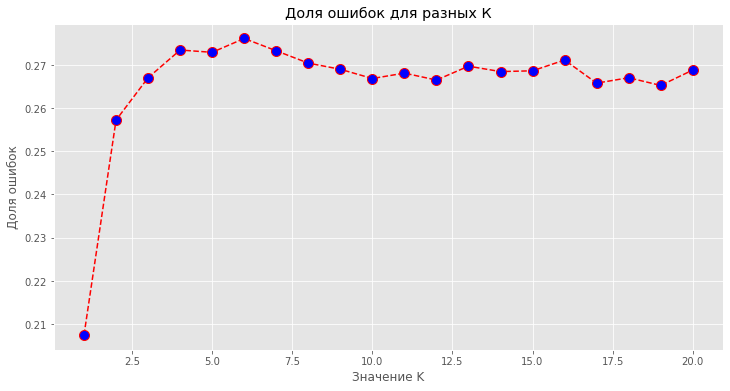

In [13]:
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 21), error_rate, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)

plt.title(u'Доля ошибок для разных К')  
plt.xlabel(u'Значение K')  
plt.ylabel(u'Доля ошибок') 

Опираясь на график, выбираю значение k равное 5.

In [14]:
#  Построение классификатора
#  Число соседей - 5
#  По умолчанию Евклидово расстояние

classifier = KNeighborsClassifier(n_neighbors=5, 
        algorithm='auto',
        leaf_size=30,
        metric='minkowski',
        p=2,
        metric_params=None,
        n_jobs=1,
        weights='uniform')  
classifier.fit(X_train_2, y_train)  

KNeighborsClassifier(n_jobs=1)

In [15]:
#  Используем классификатор на обучающей и тестовой выборках

y_pred_train = classifier.predict(X_train_2)  
y_pred_test = classifier.predict(X_test_2)

In [16]:
#  Измеряем, насколько хороша модель

print(u'Таблица сопряженности для обучающей выборки')
conf_mat = confusion_matrix(y_train, y_pred_train)

conf_mat_train = pd.DataFrame(conf_mat, index=classifier.classes_, columns=classifier.classes_)
conf_mat_train

Таблица сопряженности для обучающей выборки


,0,1
0,6008,938
1,1196,3248


In [17]:
print('Accuracy на обучающей выборке', accuracy_score(y_train, y_pred_train, normalize=True))

Accuracy на обучающей выборке 0.8126426690079017


In [18]:
print(classification_report(y_pred_train, y_train))

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      7204
           1       0.73      0.78      0.75      4186

    accuracy                           0.81     11390
   macro avg       0.80      0.80      0.80     11390
weighted avg       0.82      0.81      0.81     11390



In [19]:
print(u'Таблица сопряженности для тестовой выборки')

conf_mat = confusion_matrix(y_test, y_pred_test)

conf_mat_test = pd.DataFrame(conf_mat, index=classifier.classes_, columns=classifier.classes_)
conf_mat_test

Таблица сопряженности для тестовой выборки


,0,1
0,2733,685
1,846,1346


In [20]:
print('Accuracy на тестовой выборке', accuracy_score(y_test, y_pred_test, normalize=True))

Accuracy на тестовой выборке 0.7270944741532976


In [21]:
print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78      3579
           1       0.61      0.66      0.64      2031

    accuracy                           0.73      5610
   macro avg       0.71      0.71      0.71      5610
weighted avg       0.73      0.73      0.73      5610



**Вывод:** accuracy на обучающей выборке равна 81%, на тестовой - 73%. Разница в 8% показывает, что есть небольшое переобучение. Также метрики качества говорят о том, что precision у класса 0 выше, чем у класса 1 даже после балансировки классов.